In [119]:
import numpy as np
import pandas as pd
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available. Training on CPU...")
else:
  print("CUDA is available. Training on GPU..")

CUDA is available. Training on GPU..


## Image Loading

In [0]:
import pickle

with open('train_image.pkl', 'rb') as f:
    data = pickle.load(f)

In [0]:
with open('test_image.pkl', 'rb') as f:
    data2 = pickle.load(f)

In [0]:
torch.set_default_tensor_type('torch.FloatTensor')

In [0]:
with open('train_label.pkl', 'rb') as f:
    label = pickle.load(f)

In [147]:
max(label)

6

In [0]:
data = np.array(data)

In [0]:
data2 = np.array(data2)

In [0]:
data = data.reshape(8000, 28,28)

In [0]:
data2 = data2.reshape(2000, 28, 28)

In [152]:
data.shape

(8000, 28, 28)

In [153]:
data2.shape

(2000, 28, 28)

In [0]:
data = torch.FloatTensor(data)

In [0]:
data2 = torch.FloatTensor(data2)

### Prepare for model

In [0]:
from PIL import Image
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

class MyImages(torch.utils.data.Dataset):
  
  def __init__(self,
                 images,
                 labels,
                 train=True,
                 transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train # training set or test set
    
    
  def __getitem__(self, index):
    img, target = self.images[index], self.labels[index]

    img = Image.fromarray(img.squeeze().numpy(), mode='F')
    
    if self.transform is not None:
      img = self.transform(img)
    
    return img, target
  
  def __len__(self):
        """Return size of dataset."""
        return len(self.labels)

In [0]:
class MyTestImages(torch.utils.data.Dataset):
  
  def __init__(self,
                 images,
                 transform=None):
    self.images = images
    self.transform = transform
    
    
  def __getitem__(self, index):
    img, target = self.images[index], index

    img = Image.fromarray(img.squeeze().numpy(), mode='F')
    
    if self.transform is not None:
      img = self.transform(img)
    
    return img, target
  
  def __len__(self):
        """Return size of dataset."""
        return self.images.shape[0]

In [0]:


# num of subporcesses for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 16

# percentage of training set to use as validation data
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_data = MyImages(data, label, transform = transform)
test_data = MyTestImages(data2, transform = transform_test)

# obtaining training indices that will be used for validataion
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler = train_sampler,
                                           num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler = valid_sampler,
                                           num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          num_workers = num_workers)

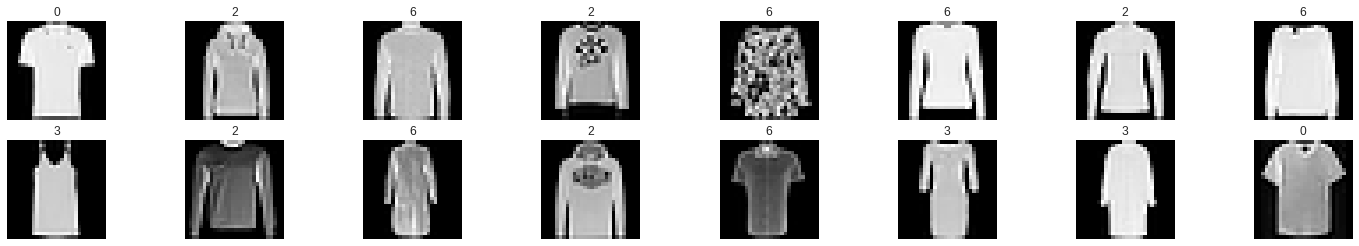

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline 

#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

images.numpy()


# plot the images in the batch
fig = plt.figure(figsize=(25,4))
for idx in np.arange(16):
  ax = fig.add_subplot(2, 16/2, idx + 1, xticks = [], yticks = [])
  ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
  # print out the correct labels for each image
  ax.set_title(str(labels[idx].item()))

## Defining the Architecture

In [137]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
     # convolutional layer (sees 28 x 28 x 1 tensor)
    self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
    self.conv1b = nn.Conv2d(16, 24, 3, padding = 1)
    
    # convolutional layer (sees 14 x 14 x 16 tensor)
    self.conv2 = nn.Conv2d(24, 32, 3, padding = 1)
    self.conv2b = nn.Conv2d(32, 48, 3, padding = 1)
    # convolutional layer (sees 7 x 7 x 32 tensor)
    self.conv3 = nn.Conv2d(48, 64, 3, padding = 1)
    
    # maxpool layers
    self.pool = nn.MaxPool2d(2,2)
    
    # linear layer
    self.fc1 = nn.Linear(64 * 3 * 3, 512)
    # linear layer (512 -> 10)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 7)
    
    # dropout layer (p = 0.25)
    self.dropout = nn.Dropout(0.25)
  
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv1b(x)))
    x = F.relu(self.conv2(x))
    x = self.pool(F.relu(self.conv2b(x)))
    x = self.pool(F.relu(self.conv3(x)))
    
    # flatten the image
    x = x.view(-1, 64 * 3 * 3)
    
    # add dropout
    x = self.dropout(x)
    # add first hidden layer with relu activation
    x = F.relu(self.fc1(x))
    #add dropout
    x = self.dropout(x)
    
    # add second hidden layer
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    
    x = self.fc3(x)
    
    return x
  
#initialize the NN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
# specify the loss function
criterion = nn.CrossEntropyLoss()

# specify the optimizer and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [139]:
# number of epochs to train the model
n_epochs = 50 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    correct = 0
    total = 0
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        values, indices = torch.max(output, 1)
        correct += torch.sum(indices == target)
        total += batch_size
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    accuracy = (correct * 100.0) / total
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} Validation Accuracy {:.2f}'.format(
        epoch, train_loss, valid_loss, accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.703944 	Validation Loss: 0.127623 Validation Accuracy 73.00
Validation loss decreased (inf --> 0.127623).  Saving model ...
Epoch: 2 	Training Loss: 0.507227 	Validation Loss: 0.105832 Validation Accuracy 79.00
Validation loss decreased (0.127623 --> 0.105832).  Saving model ...
Epoch: 3 	Training Loss: 0.439404 	Validation Loss: 0.106683 Validation Accuracy 78.00
Epoch: 4 	Training Loss: 0.397196 	Validation Loss: 0.100291 Validation Accuracy 81.00
Validation loss decreased (0.105832 --> 0.100291).  Saving model ...
Epoch: 5 	Training Loss: 0.366492 	Validation Loss: 0.084921 Validation Accuracy 83.00
Validation loss decreased (0.100291 --> 0.084921).  Saving model ...
Epoch: 6 	Training Loss: 0.347569 	Validation Loss: 0.084741 Validation Accuracy 83.00
Validation loss decreased (0.084921 --> 0.084741).  Saving model ...
Epoch: 7 	Training Loss: 0.320385 	Validation Loss: 0.081085 Validation Accuracy 84.00
Validation loss decreased (0.084741 --> 0.081085). 

## Test Image

In [0]:
import pickle

with open('test_image.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [116]:
len(test_data)

2000

In [0]:
image_index = []

In [0]:
image_label = []

In [0]:
model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
   
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = pred[i]
        image_index.append(target[i].cpu().numpy().item())
        image_label.append(label.cpu().numpy().item())        

In [0]:
image_index

In [0]:
plot_label = np.array(image_label)

In [0]:
plot_train_label = np.array(label)

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


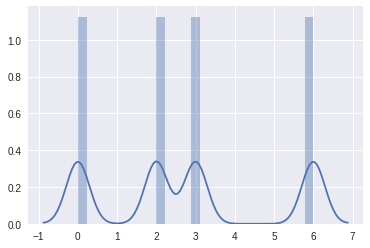

In [208]:
sns.distplot(plot_train_label)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


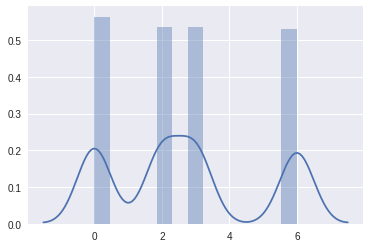

In [0]:
sns.distplot(plot_label)